## Code for Final Project: Phys 25000 Computational Physics

#### Creating A Restricted Hartree-Fock SCF Function & Generating Potential Energy Curves 
Author: Abby Pavlicek

Credits: Ruhee D'Cunha, Laura Gagliardi, D.A. Sirianni (Psi4)

Psi4 documentation: https://psicode.org/ , https://psicode.org/psi4manual/master/psiapi.html

### Pseudocode

Given:
- Geometry of a molecule
- Charge and spin multiplicity of a molecule ?
- Basis set
- Max iterations/cycles, memory and convergence criterion

I want a function that returns:
- Ground state RHF energy
- Maybe: Number of iterations, intermediate energies prior to convergence, delta E after each cycle? 
- Maybe: spin? to check for spin contamination??

##### Algorithm
Given initial settings (geom, charge, spin, basis="",max_it = 50, mem=#,energy_tol=#), calculate
- Overlap matrix S
- Core hamiltonian: H = T + V
- Initial transformed Fock mat F'
- Initial transformed orbital coeff mat C' and density mat P

- Nuclear repulsion energy E$_{nuc}$ !!

SCF procedure

For iterations < max iteration, and for delta_energy > tol : 

1. Build fock matrix F

    i. build coloumb matrix J, exchange matrix K
    
    ii. F = H + J - (1/2)K
   
   
2. Find energy: F'C' = C'$\epsilon$ ; E$_{total}$ = E$_{elec}$ + E$_{nuc}$


3. Check for convergence: dE > tol ? 

    i. if converged, return energy, break
    
    ii. if iteration # = max_iteration, break
    
    
4. Else: make a new guess

    i. need new transformed fock mat F', new orbital coeff mat C' and new density mat P

In [1]:
#import python modules
import numpy as np
import psi4 

#psi4 documentation: presets
psi4.set_memory('500 MB')

#input geometry is in zmat format: here are a whole bunch of test molecules. Most geoms taken from CCCBDB - experimental. 
H2 = psi4.geometry("""
H
H 1 0.74
""") 

N2 = psi4.geometry("""
N
N 1 1.098
""")

O2 = psi4.geometry("""
O
O 1 1.208
""")

H2O = psi4.geometry("""
H 0.0000	0.7572	-0.4692
O 0.0000	0.0000	0.1173
H 0.0000	-0.7572	-0.4692
""")

CH4 = psi4.geometry("""
C	0.0000	0.0000	0.0000
H	0.6276	0.6276	0.6276
H	0.6276	-0.6276	-0.6276
H	-0.6276	0.6276	-0.6276
H	-0.6276	-0.6276	0.6276
""")

CH3COOH = psi4.geometry("""
C
C 1 1.51
O 1 1.21 2 126
O 1 1.36 2 111 3 180
H 4 0.98 1 105 3 0
H 2 1.09 1 109 3 0
H 2 1.09 1 109 6 -120
H 2 1.09 1 109 6 120
""")

HCN = psi4.geometry("""
C	0.0000	0.0000	-0.5001
H	0.0000	0.0000	-1.5700
N	0.0000	0.0000	0.6529
""")

In [2]:
def my_rhf_scf(mol,basis,output,damping=0.0,E_conv=1.0e-6,MAX_IT=50):
    
    #### See Psi4 documentation: specifically psi4.core and psi4.core.MintsHelper #### 
    #### See Numpy's eigensolver documentation ####
    psi4.core.clean()
    psi4.core.set_output_file(output,False)
    psi4.set_options({'basis':basis,
                 'scf_type':'pk',
                 'diis':True,
                 'reference': 'rhf',
                 'e_convergence':E_conv})
    
    #compute static 1e- and 2e- quantities
    wfxn = psi4.core.Wavefunction.build(mol, psi4.core.get_global_option('basis'), quiet=True)
    mints = psi4.core.MintsHelper(wfxn.basisset())
    
    #overlap matrix
    S = np.asarray(mints.ao_overlap())
    A = mints.ao_overlap()
    A.power(-0.5,1e-16)
    A = np.asarray(A)
    #number of basis functions and doubly occupied orbitals
    nbf = S.shape[0]
    ndocc = wfxn.nalpha()
    
    print('Number of occupied orbitals: %3d' % (ndocc))
    print('Number of basis functions: %3d' % (nbf))
    
    #memory check for ERI tensor
    numpy_memory = 2
    I_size = (nbf**4) * 8.e-9
    #print('\nSize of the ERI tensor will be {:4.2f} GB.'.format(I_size))
    if I_size > numpy_memory:
        psi4.core.clean()
        raise Exception("Estimated memory utilization exceeds allotted memory limit")
    #build ERI tensor
    I = np.asarray(mints.ao_eri())
    
    #build core Hamiltonian
    T = np.asarray(mints.ao_kinetic())
    V = np.asarray(mints.ao_potential())
    H = T + V 
    
    #nuclear repulsion energy
    E_nuc = mol.nuclear_repulsion_energy()
    #print(E_nuc)

    #generate initial guess of density matrix 
    F_prime = A.dot(H).dot(A)                                           
    e, C_prime = np.linalg.eigh(F_prime)
    C = A.dot(C_prime)                                        
    C_occ = C[:, :ndocc]
    P = 2*np.einsum('pi,qi->pq', C_occ, C_occ, optimize=True)
    
    #now we are ready to start the iterative procedure
    E_SCF = 0.0
    E_old = 0.0
    
    print('==> Starting SCF Iterations <==\n')
    
    for scf_iter in range(1, MAX_IT + 1):
        #compute integrals 
        J = np.einsum('pqrs,rs->pq', I, P, optimize=True)
        K = np.einsum('pqrs,pr->qs', I, P, optimize=True) 
        F = H + J - 0.5*K
        #compute RHF energy 
        E_SCF = 0.5*np.einsum('pq,pq->', (H+F), P, optimize=True) + E_nuc
       
        print('SCF Iteration %3d: Energy = %4.16f dE = % 1.5E' % (scf_iter, E_SCF, E_SCF - E_old))       
        
        #check for convergence
        if (abs(E_SCF - E_old) < E_conv):
            break
        E_old = E_SCF 
        
        #check for max iterations exceeded
        if (scf_iter == MAX_IT):
            psi4.core.clean()
            raise Exception("Maximum number of SCF iterations exceeded.")
        
        #compute new orbital guess (new density matrix), rinse and repeat
        
        F_prime = A.dot(F).dot(A)
        e, C_prime = np.linalg.eigh(F_prime)
        C = A.dot(C_prime)
        C_occ = C[:, :ndocc]
        P_old = P
        P_new = 2 * np.einsum('pi,qi->pq', C_occ, 
                              C_occ, optimize=True)
        P = P_new - damping*(P_new - P_old) #damping factor if needed to avoid oscillatory behavior & improve convergence

    
        
    print('SCF converged')
    print('Final RHF Energy: %.8f [Eh]' % (E_SCF))
    
    #compare to Psi4's built in RHF function
    psi4.core.set_active_molecule(mol)
    SCF_E_psi = psi4.energy(f'SCF/{basis}')
    print('Psi4 SCF Energy: ' + str(SCF_E_psi))
    print(abs(SCF_E_psi - E_SCF))
    #psi4.compare_values(SCF_E_psi, E_SCF, 6, 'SCF Energy')

### Testing RHF function for different molecules

In [236]:
my_rhf_scf(H2,basis='sto-3g',output='out.out')

Number of occupied orbitals:   1
Number of basis functions:   2
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -1.1167593073781570 dE = -1.11676E+00
SCF Iteration   2: Energy = -1.1167593073781574 dE = -4.44089E-16
SCF converged
Final RHF Energy: -1.11675931 [Eh]
Psi4 SCF Energy: -1.1167593073781577


In [284]:
my_rhf_scf(H2O,basis='sto-3g',output='out.out')

Number of occupied orbitals:   5
Number of basis functions:   7
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -73.2327241459430809 dE = -7.32327E+01
SCF Iteration   2: Energy = -74.9457879610122006 dE = -1.71306E+00
SCF Iteration   3: Energy = -74.9621676039969600 dE = -1.63796E-02
SCF Iteration   4: Energy = -74.9629069271506125 dE = -7.39323E-04
SCF Iteration   5: Energy = -74.9630029678972676 dE = -9.60407E-05
SCF Iteration   6: Energy = -74.9630194396861214 dE = -1.64718E-05
SCF Iteration   7: Energy = -74.9630224485926249 dE = -3.00891E-06
SCF Iteration   8: Energy = -74.9630230091561884 dE = -5.60564E-07
SCF converged
Final RHF Energy: -74.96302301 [Eh]
Psi4 SCF Energy: -74.96302313852722
1.2937103122112603e-07


In [285]:
my_rhf_scf(N2,basis='sto-3g',output='out.out',damping=0.2,MAX_IT=500)

Number of occupied orbitals:   7
Number of basis functions:  10
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -104.0960344048719293 dE = -1.04096E+02
SCF Iteration   2: Energy = -106.1185845365798031 dE = -2.02255E+00
SCF Iteration   3: Energy = -106.6301153880176145 dE = -5.11531E-01
SCF Iteration   4: Energy = -106.7387610510584608 dE = -1.08646E-01
SCF Iteration   5: Energy = -106.7609720484435201 dE = -2.22110E-02
SCF Iteration   6: Energy = -106.7654624420775491 dE = -4.49039E-03
SCF Iteration   7: Energy = -106.7663665082693143 dE = -9.04066E-04
SCF Iteration   8: Energy = -106.7665481994573184 dE = -1.81691E-04
SCF Iteration   9: Energy = -106.7665846850761255 dE = -3.64856E-05
SCF Iteration  10: Energy = -106.7665920096927863 dE = -7.32462E-06
SCF Iteration  11: Energy = -106.7665934801315899 dE = -1.47044E-06
SCF Iteration  12: Energy = -106.7665937753763075 dE = -2.95245E-07
SCF converged
Final RHF Energy: -106.76659378 [Eh]
Psi4 SCF Energy: -107.49597503073177

In [286]:
my_rhf_scf(O2,basis='sto-3g',output='out.out',damping=0.3,MAX_IT=100)

Number of occupied orbitals:   8
Number of basis functions:  10
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -144.6775646476799295 dE = -1.44678E+02
SCF Iteration   2: Energy = -146.1749249087081637 dE = -1.49736E+00
SCF Iteration   3: Energy = -146.7476860070791247 dE = -5.72761E-01
SCF Iteration   4: Energy = -146.9335183605766986 dE = -1.85832E-01
SCF Iteration   5: Energy = -146.9909349413906909 dE = -5.74166E-02
SCF Iteration   6: Energy = -147.0083743654171258 dE = -1.74394E-02
SCF Iteration   7: Energy = -147.0136362010328526 dE = -5.26184E-03
SCF Iteration   8: Energy = -147.0152192986243165 dE = -1.58310E-03
SCF Iteration   9: Energy = -147.0156949694519710 dE = -4.75671E-04
SCF Iteration  10: Energy = -147.0158378006144630 dE = -1.42831E-04
SCF Iteration  11: Energy = -147.0158806744608171 dE = -4.28738E-05
SCF Iteration  12: Energy = -147.0158935415957160 dE = -1.28671E-05
SCF Iteration  13: Energy = -147.0158974028248622 dE = -3.86123E-06
SCF Iteration  14: 

In [287]:
my_rhf_scf(CH4,basis='sto-3g',output='out.out',damping=0.0,MAX_IT=100)

Number of occupied orbitals:   5
Number of basis functions:   9
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -36.0817064143022961 dE = -3.60817E+01
SCF Iteration   2: Energy = -39.5615701582278803 dE = -3.47986E+00
SCF Iteration   3: Energy = -39.7216189193910054 dE = -1.60049E-01
SCF Iteration   4: Energy = -39.7266435991500089 dE = -5.02468E-03
SCF Iteration   5: Energy = -39.7268038639553609 dE = -1.60265E-04
SCF Iteration   6: Energy = -39.7268089990962991 dE = -5.13514E-06
SCF Iteration   7: Energy = -39.7268091657975333 dE = -1.66701E-07
SCF converged
Final RHF Energy: -39.72680917 [Eh]
Psi4 SCF Energy: -39.72680917153099
5.73345459997654e-09


In [288]:
my_rhf_scf(CH3COOH,basis='sto-3g',output='out.out',damping=0.5,MAX_IT=100)

Number of occupied orbitals:  16
Number of basis functions:  24
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -206.6030636318917573 dE = -2.06603E+02
SCF Iteration   2: Energy = -216.6443828543273753 dE = -1.00413E+01
SCF Iteration   3: Energy = -220.4212993422801219 dE = -3.77692E+00
SCF Iteration   4: Energy = -222.4762823293277165 dE = -2.05498E+00
SCF Iteration   5: Energy = -223.6021558182242757 dE = -1.12587E+00
SCF Iteration   6: Energy = -224.1933613284400622 dE = -5.91206E-01
SCF Iteration   7: Energy = -224.4969277506031631 dE = -3.03566E-01
SCF Iteration   8: Energy = -224.6511141604943873 dE = -1.54186E-01
SCF Iteration   9: Energy = -224.7290148308866833 dE = -7.79007E-02
SCF Iteration  10: Energy = -224.7682756808982845 dE = -3.92609E-02
SCF Iteration  11: Energy = -224.7880428526190144 dE = -1.97672E-02
SCF Iteration  12: Energy = -224.7979936385082738 dE = -9.95079E-03
SCF Iteration  13: Energy = -224.8030046361842551 dE = -5.01100E-03
SCF Iteration  14: 

In [291]:
my_rhf_scf(HCN,basis='sto-3g',output='out.out',damping=0.5,MAX_IT=100)

Number of occupied orbitals:   7
Number of basis functions:  11
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -85.5415769198596365 dE = -8.55416E+01
SCF Iteration   2: Energy = -87.8503218885964259 dE = -2.30874E+00
SCF Iteration   3: Energy = -89.5635880788252763 dE = -1.71327E+00
SCF Iteration   4: Energy = -90.5656056327271699 dE = -1.00202E+00
SCF Iteration   5: Energy = -91.1058372758647579 dE = -5.40232E-01
SCF Iteration   6: Energy = -91.3863619643415603 dE = -2.80525E-01
SCF Iteration   7: Energy = -91.5294974487294724 dE = -1.43135E-01
SCF Iteration   8: Energy = -91.6019104682690681 dE = -7.24130E-02
SCF Iteration   9: Energy = -91.6383894833275292 dE = -3.64790E-02
SCF Iteration  10: Energy = -91.6567270780583669 dE = -1.83376E-02
SCF Iteration  11: Energy = -91.6659352147441382 dE = -9.20814E-03
SCF Iteration  12: Energy = -91.6705564923920804 dE = -4.62128E-03
SCF Iteration  13: Energy = -91.6728751187406345 dE = -2.31863E-03
SCF Iteration  14: Energy = -91.

### Generating Potential Energy Curves for H2, N2

In [3]:
## this is just a whole bunch of geometries spaced out on bond length intervals. There is definitely a more efficient way to write this...

H2_geoms_list = [
psi4.geometry("""
H
H 1 0.3
"""),
psi4.geometry("""
H
H 1 0.4
"""),
psi4.geometry("""
H
H 1 0.5
"""),
psi4.geometry("""
H
H 1 0.55
"""),
psi4.geometry("""
H
H 1 0.6
"""),
psi4.geometry("""
H
H 1 0.65
"""),
psi4.geometry("""
H
H 1 0.7
""") ,
psi4.geometry("""
H
H 1 0.74
""") ,
psi4.geometry("""
H
H 1 0.8
""") ,
psi4.geometry("""
H
H 1 0.85
""") ,
psi4.geometry("""
H
H 1 0.9
""") ,
psi4.geometry("""
H
H 1 0.95
""") ,
psi4.geometry("""
H
H 1 1.0
""") ,
psi4.geometry("""
H
H 1 1.1
""") ,
psi4.geometry("""
H
H 1 1.2
""") ,
psi4.geometry("""
H
H 1 1.3
"""), 
psi4.geometry("""
H
H 1 1.5
"""),
psi4.geometry("""
H
H 1 1.8
"""),
psi4.geometry("""
H
H 1 2.5
""")
]

In [241]:
for i in range(0,len(H2_geoms_list)):
    my_rhf_scf(H2_geoms_list[i],basis='sto-3g',output='out.out')
    

Number of occupied orbitals:   1
Number of basis functions:   2
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -0.5938277591847829 dE = -5.93828E-01
SCF Iteration   2: Energy = -0.5938277591847829 dE =  0.00000E+00
SCF converged
Final RHF Energy: -0.59382776 [Eh]
Psi4 SCF Energy: -0.5938277591847835
Number of occupied orbitals:   1
Number of basis functions:   2
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -0.9043613945444640 dE = -9.04361E-01
SCF Iteration   2: Energy = -0.9043613945444635 dE =  4.44089E-16
SCF converged
Final RHF Energy: -0.90436139 [Eh]
Psi4 SCF Energy: -0.9043613945444646
Number of occupied orbitals:   1
Number of basis functions:   2
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -1.0429962747511716 dE = -1.04300E+00
SCF Iteration   2: Energy = -1.0429962747511716 dE =  0.00000E+00
SCF converged
Final RHF Energy: -1.04299627 [Eh]
Psi4 SCF Energy: -1.0429962747511716
Number of occupied orbitals:   1
Number of basis functi

In [5]:
H2_energy_list=[-0.59382776,-0.90436139,-1.04299627,-1.07905074,-1.10112824,-1.11299655,-1.11734903,-1.11675931,-1.11085040,-1.10251055,-1.09191404,-1.07963693,-1.06610865,-1.03653887,-1.00510671,-0.97311062,-0.91087355,-0.82884815,-0.70294360]
H2_bond_list=[0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.74,0.8,0.85,0.9,0.95,1.0,1.1,1.2,1.3,1.5,1.8,2.5]
H2_psi4_list = [-0.5938277591847835,-0.9043613945444646,-1.042996274751172,-1.0790507363246542,-1.1011282423609587,-1.1129965457166389,-1.1173490349988604,-1.1167593073781577,-1.1108503974239055,-1.1025105538476563,-1.0919140409220973,-1.0796369280940206, -1.0661086491853164, -1.03653887486935,-1.0051067063876664,-0.9731106155813937,-0.9108735543822698,-0.8288481477185704,-0.7029435995786045]

Text(1.45, -0.6, 'Equilibrium Bond Length: 0.74 A')

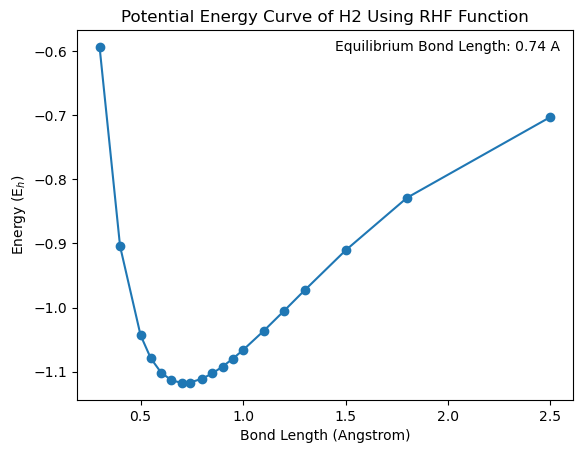

In [6]:
import matplotlib.pyplot as plt

#plt.plot(H2_bond_list,H2_psi4_list,'-o')
plt.plot(H2_bond_list,H2_energy_list,'-o')
plt.title("Potential Energy Curve of H2 Using RHF Function")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy (E$_{h}$)")
plt.text(1.45,-0.6,"Equilibrium Bond Length: 0.74 A")


[-0.46958125  0.70663097  3.14741282  2.78441091  3.15177888 -0.64762436]


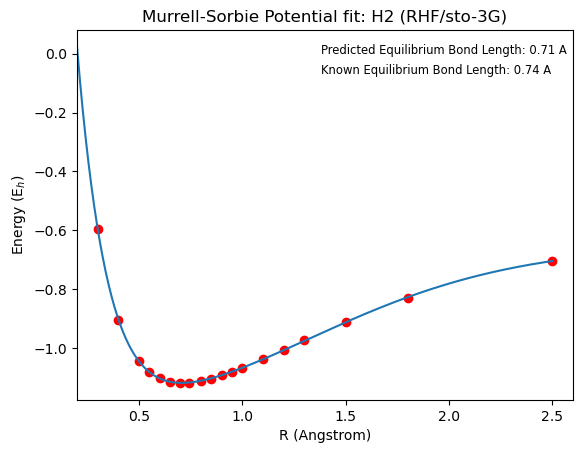

In [7]:
#fitting to a Murrell-Sorbie potential function. Form is defined in the ms function below

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

#xdata: array of rvals
xdata2=np.array(H2_bond_list)
ydata2=H2_energy_list
#ydata: list of energy

t=np.linspace(0.2,2.5,500)

tstart = [1.e+7, 0.7, 1, 1 ,1, 0]
def ms(x, q, u, a, b, c, z):
    return q*(1 + a*(x-u) + b*((x-u)**2) + c*((x-u)**3))*np.exp(-a *(x-u)) + z

popt, pcov = curve_fit(ms, xdata2, ydata2, p0 = tstart,  maxfev=40000000)
print(popt)

yfit = ms(t, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])

#print popt
#
#
#
plt.plot(xdata2, ydata2,"ro")
plt.plot(t, yfit)
plt.title("Murrell-Sorbie Potential fit: H2 (RHF/sto-3G)")
plt.xlabel("R (Angstrom)")
plt.ylabel("Energy (E$_{h}$)")
plt.ticklabel_format(useOffset=False)
plt.xlim(0.2,2.6)
plt.text(1.38,-0.0,"Predicted Equilibrium Bond Length: 0.71 A",fontsize='small')
plt.text(1.38,-0.07,"Known Equilibrium Bond Length: 0.74 A",fontsize='small')

plt.savefig("h2pec.jpg",dpi=1000,format='jpg',bbox_inches='tight')

In [156]:
N2_geoms_list = [psi4.geometry("""
N
N 1 0.4
"""),
psi4.geometry("""
N
N 1 0.6
"""), 
psi4.geometry("""
N
N 1 0.8
"""),
psi4.geometry("""
N
N 1 0.9
"""),
psi4.geometry("""
N
N 1 1.0
"""),
psi4.geometry("""
N
N 1 1.1
"""),
psi4.geometry("""
N
N 1 1.2
"""),
psi4.geometry("""
N
N 1 1.3
"""),
psi4.geometry("""
N
N 1 1.5
"""),
psi4.geometry("""
N
N 1 1.8
""")            
    ]

In [259]:
for i in range(0,len(N2_geoms_list)):
    my_rhf_scf(N2_geoms_list[i],basis='sto-3g',output='out.out',damping=0.3,MAX_IT=500)

SCF converged
Final RHF Energy: -94.45642769 [Eh]
Psi4 SCF Energy: -94.45642784400758
SCF converged
Final RHF Energy: -103.88071542 [Eh]
Psi4 SCF Energy: -103.88071561270192
SCF converged
Final RHF Energy: -106.68080224 [Eh]
Psi4 SCF Energy: -106.6808024592972
SCF converged
Final RHF Energy: -107.18719001 [Eh]
Psi4 SCF Energy: -107.18719030250315
SCF converged
Final RHF Energy: -107.41953218 [Eh]
Psi4 SCF Energy: -107.4195324523425
SCF converged
Final RHF Energy: -106.76967369 [Eh]
Psi4 SCF Energy: -107.49650051193096
SCF converged
Final RHF Energy: -106.88157076 [Eh]
Psi4 SCF Energy: -107.48778392783986
SCF converged
Final RHF Energy: -106.93565380 [Eh]
Psi4 SCF Energy: -107.43387068963219
SCF converged
Final RHF Energy: -106.95940630 [Eh]
Psi4 SCF Energy: -107.27244850058743
SCF converged
Final RHF Energy: -106.72830939 [Eh]
Psi4 SCF Energy: -107.01732690661794


In [254]:
n2_bonds = [0.4,0.6,0.8,0.9,1.0,1.1,1.2,1.3,1.5,1.8]
n2_myrhf = [-94.45642778,-103.88071553,-106.68080236,-107.18719017,-107.41953233,-106.76967378,-106.88157084,-106.93565387,-106.95940663 ,-106.72830949]
n2_psi4 = [-94.45642784400758,-103.88071561270192,-106.6808024592972,-107.18719030250315,-107.4195324523425,-107.49650051193096,-107.48778392783986,-107.43387068963219,-107.27244850058743,-107.01732690661794]

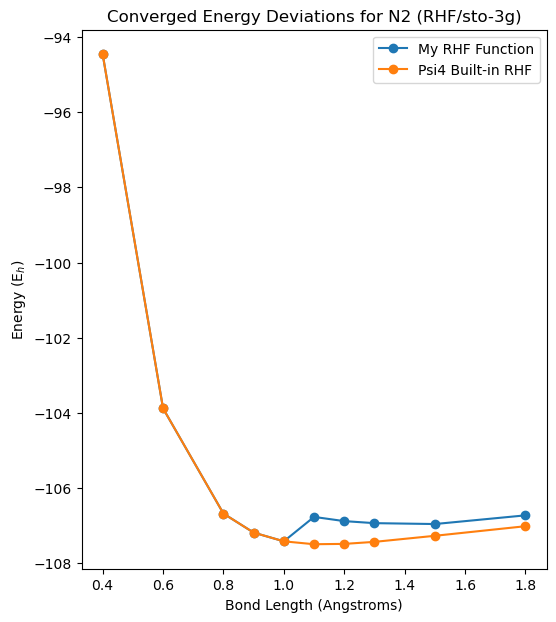

In [295]:
plt.rcParams['figure.figsize'] = [6,7]
plt.plot(n2_bonds,n2_myrhf,'-o',label="My RHF Function")
plt.plot(n2_bonds,n2_psi4,'-o',label="Psi4 Built-in RHF")
plt.legend()
plt.title("Converged Energy Deviations for N2 (RHF/sto-3g)")
plt.xlabel("Bond Length (Angstroms)")
plt.ylabel("Energy (E$_{h}$)")

plt.savefig("n2pec.jpg",dpi=1000,format='jpg',bbox_inches='tight')

Because my function works for many other molecules, as tested above, I think this is a breakdown in the simplicity of my method rather than an error of the code itself. Psi4 clearly has a more robust convergence method than my elementary dE, which shows in a more complicated high-energy bonded molecule like N2. 